<a href="https://colab.research.google.com/github/jcsmcmendes/Step_Class/blob/main/Preparing_data_for_supervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import libraries
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.metrics import f1_score

In [2]:
#Load data and define input variables (features) from the target variable (label)
df = pd.read_excel("Student_datasets.xlsx", sheet_name="classification")
X = df[['attendance', 'assignments_completed', 'participation']]
y = df['passed']
print('Input variables:', X.head())
print('Target variables:', y.head())

Input variables:    attendance  assignments_completed  participation
0          51                      6              2
1          92                      5              1
2          14                      7              0
3          71                     10              4
4          60                      8              3
Target variables: 0    0
1    0
2    0
3    1
4    0
Name: passed, dtype: int64


Class distribution: Counter({0: 176, 1: 24})


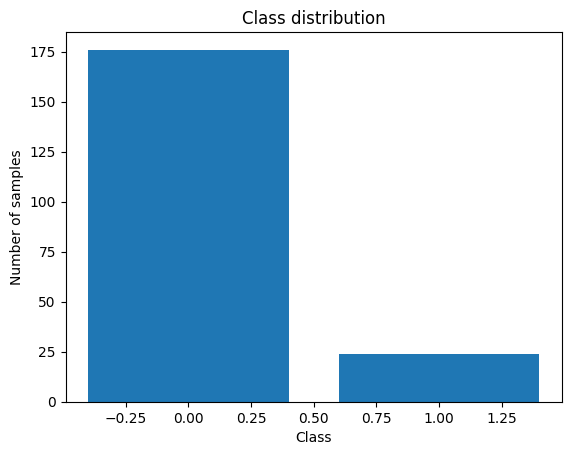

In [3]:
counter = Counter(y)
print("Class distribution:", counter)

# Optional: Bar plot
plt.bar(counter.keys(), counter.values())
plt.title("Class distribution")
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.show()

## ⚖️ Handling Class Imbalance: Validation Options

After identifying class imbalance in our dataset, we have three main strategies to evaluate our models fairly:

---

### 1️⃣ K-Fold Cross-Validation + Balanced Training Folds

- We apply **K-Fold Cross-Validation** on the training data.
- **Resampling techniques (e.g. SMOTE, oversampling, undersampling)** are applied **only within the training portion of each fold**.
- The validation fold remains untouched and original.
- ✅ Most robust and widely accepted approach.

---

### 2️⃣ Repeated Random Train/Test Splits + Balanced Training Sets

- We randomly split the data into training and test sets **multiple times** (e.g. 5 repetitions).
- In each repetition, the training set is **balanced**, and evaluation is done on the untouched test set.
- ✅ Useful when K-Fold is not ideal, or for simpler pipelines.

---

### 3️⃣ Single Train/Test Split + One-Time Resampling

- We split the data once into training and test sets.
- Apply resampling only to the training set.
- The test set is used for final evaluation.
- ❗ Less robust — results may vary depending on the random split.

---

> 💡 Choosing the right approach depends on the context, dataset size, and the goal of your analysis.


## 1️⃣ K-Fold Cross-Validation + Balanced Training Folds

In [4]:
# 🔁 Modelo base
model = LogisticRegression()

### 1️⃣ K-Fold Cross-Validation + SMOTE
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores_kfold = []
acc_scores_kfold = []

for train_idx, val_idx in skf.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    X_train_smote, y_train_smote = SMOTE(random_state=42).fit_resample(X_train_scaled, y_train)

    model.fit(X_train_smote, y_train_smote)
    preds = model.predict(X_val_scaled)

    f1_scores_kfold.append(f1_score(y_val, preds, average='macro'))
    acc_scores_kfold.append(accuracy_score(y_val, preds))

mean_kfold_f1 = np.mean(f1_scores_kfold)
mean_kfold_acc = np.mean(acc_scores_kfold)

### 2️⃣ Repeated Random Holdout + SMOTE
f1_scores_repeated = []
acc_scores_repeated = []

for seed in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=seed)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_smote, y_train_smote = SMOTE(random_state=42).fit_resample(X_train_scaled, y_train)

    model.fit(X_train_smote, y_train_smote)
    preds = model.predict(X_test_scaled)

    f1_scores_repeated.append(f1_score(y_test, preds, average='macro'))
    acc_scores_repeated.append(accuracy_score(y_test, preds))

mean_repeated_f1 = np.mean(f1_scores_repeated)
mean_repeated_acc = np.mean(acc_scores_repeated)

### 3️⃣ Single Split + SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_smote, y_train_smote = SMOTE(random_state=42).fit_resample(X_train_scaled, y_train)

model.fit(X_train_smote, y_train_smote)
preds = model.predict(X_test_scaled)

f1_single = f1_score(y_test, preds, average='macro')
acc_single = accuracy_score(y_test, preds)

# 📊 Resultados finais
print("📈 Performance Comparison (Macro F1 and Accuracy):\n")
print(f"1️⃣ K-Fold:        F1 = {round(mean_kfold_f1, 3)}, Accuracy = {round(mean_kfold_acc, 3)}")
print(f"2️⃣ Repeated Split: F1 = {round(mean_repeated_f1, 3)}, Accuracy = {round(mean_repeated_acc, 3)}")
print(f"3️⃣ Single Split:   F1 = {round(f1_single, 3)}, Accuracy = {round(acc_single, 3)}")

📈 Performance Comparison (Macro F1 and Accuracy):

1️⃣ K-Fold:        F1 = 0.744, Accuracy = 0.875
2️⃣ Repeated Split: F1 = 0.758, Accuracy = 0.855
3️⃣ Single Split:   F1 = 0.771, Accuracy = 0.9


## 🔁 Testing different Models to do the classification

In [8]:
# 🔁 Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(max_depth=4, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

# 📊 Store results
results = []

# 🧪 Loop through each model
for model_name, model in models.items():

    # 1️⃣ K-Fold CV + SMOTE
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_kfold, acc_kfold = [], []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        X_train_res, y_train_res = SMOTE(random_state=42).fit_resample(X_train_scaled, y_train)

        model.fit(X_train_res, y_train_res)
        preds = model.predict(X_val_scaled)

        f1_kfold.append(f1_score(y_val, preds, average='macro'))
        acc_kfold.append(accuracy_score(y_val, preds))

    # 2️⃣ Repeated Holdout (5 splits)
    f1_rep, acc_rep = [], []

    for seed in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=seed)

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        X_train_res, y_train_res = SMOTE(random_state=42).fit_resample(X_train_scaled, y_train)

        model.fit(X_train_res, y_train_res)
        preds = model.predict(X_test_scaled)

        f1_rep.append(f1_score(y_test, preds, average='macro'))
        acc_rep.append(accuracy_score(y_test, preds))

    # 3️⃣ Single Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_res, y_train_res = SMOTE(random_state=42).fit_resample(X_train_scaled, y_train)

    model.fit(X_train_res, y_train_res)
    preds = model.predict(X_test_scaled)

    f1_single = f1_score(y_test, preds, average='macro')
    acc_single = accuracy_score(y_test, preds)

    # 📥 Store results
    results.append({
        'Model': model_name,
        'F1 KFold': round(np.mean(f1_kfold), 3),
        'Acc KFold': round(np.mean(acc_kfold), 3),
        'F1 Repeated': round(np.mean(f1_rep), 3),
        'Acc Repeated': round(np.mean(acc_rep), 3),
        'F1 Single': round(f1_single, 3),
        'Acc Single': round(acc_single, 3)
    })
results_df = pd.DataFrame(results)
mean_row = results_df.select_dtypes(include=np.number).mean().round(3)
std_row = results_df.select_dtypes(include=np.number).std().round(3)
mean_row['Model'] = 'Mean'
std_row['Model'] = 'Std'

cols = ['Model'] + [col for col in results_df.columns if col != 'Model']
results_df = pd.concat([results_df, mean_row.to_frame().T, std_row.to_frame().T], ignore_index=True)[cols]


print(results_df)


                 Model F1 KFold Acc KFold F1 Repeated Acc Repeated F1 Single  \
0  Logistic Regression    0.744     0.875       0.758        0.855     0.771   
1                  KNN    0.748     0.855       0.776         0.88     0.687   
2        Decision Tree    0.751     0.895       0.775        0.875     0.722   
3        Random Forest    0.778      0.91       0.824         0.93     0.687   
4              XGBoost    0.767      0.91       0.758        0.915     0.722   
5                 Mean    0.758     0.889       0.778        0.891     0.718   
6                  Std    0.014     0.024       0.027        0.031     0.035   

  Acc Single  
0        0.9  
1      0.875  
2        0.9  
3      0.875  
4        0.9  
5       0.89  
6      0.014  
